## load images and bboxes

In [1]:
import numpy as np
from scipy.misc import face
from scipy.ndimage import zoom
from scipy.special import logsumexp
import torch
import matplotlib.pyplot as plt
import deepgaze_pytorch

/home/thomas/miniconda3/envs/deepgaze_env/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_path = "/home/thomas/Desktop/Scene-Graph-Benchmark.pytorch-master/test_img_2/input"
bbox_path = "/home/thomas/Desktop/Scene-Graph-Benchmark.pytorch-master/test_img_2/output/custom_prediction.json"
gazePrediction_path = "/home/thomas/Desktop/Scene-Graph-Benchmark.pytorch-master/test_img_2/output_cleaned"

In [3]:
from PIL import Image
import numpy as np
import os
import json

def images_to_rgb_tuples(image_folder):
    """
    Converts each image in a folder to a list of tuples containing RGB values of each pixel.

    Parameters:
    - image_folder: Path to the folder containing images.

    Returns:
    - images_rgb: A dictionary with image filenames as keys and lists of RGB tuples as values.
    """
    images_rgb = {}
    
    # Iterate over each file in the folder
    for filename in os.listdir(image_folder):
        file_path = os.path.join(image_folder, filename)
        
        # Ensure file is an image
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
            # Open the image
            with Image.open(file_path) as img:
                # Convert image to RGB if it's not already
                img = img.convert("RGB")
                
                # Convert the image to an array of RGB tuples
                rgb_array = np.array(img)

                # Store the result in the dictionary
                images_rgb[filename] = rgb_array
    
    return images_rgb

In [4]:
img_rgb_list = images_to_rgb_tuples(dataset_path)
with open(bbox_path, 'r') as file:
        bbox_data = json.load(file)

In [5]:
img_rgb_list['img_3.jpg']

array([[[ 99, 143, 204],
        [ 99, 143, 204],
        [ 99, 143, 204],
        ...,
        [199, 214, 237],
        [200, 215, 238],
        [200, 215, 238]],

       [[ 99, 143, 204],
        [ 99, 143, 204],
        [ 99, 143, 204],
        ...,
        [200, 215, 238],
        [200, 215, 238],
        [200, 215, 238]],

       [[ 98, 144, 204],
        [ 98, 144, 204],
        [ 98, 144, 204],
        ...,
        [200, 215, 238],
        [200, 215, 238],
        [201, 216, 239]],

       ...,

       [[230, 213, 195],
        [229, 212, 194],
        [229, 212, 194],
        ...,
        [252, 244, 233],
        [252, 244, 233],
        [252, 244, 233]],

       [[230, 217, 200],
        [231, 218, 201],
        [231, 218, 201],
        ...,
        [252, 242, 232],
        [252, 242, 232],
        [252, 242, 232]],

       [[233, 220, 203],
        [233, 220, 203],
        [233, 220, 203],
        ...,
        [252, 242, 232],
        [252, 242, 232],
        [252, 242, 232]]

In [6]:
bbox_data["0"]['bbox']

[[476.5, 340.5, 683.5, 520.0],
 [472.5, 63.40625, 544.0, 117.6875],
 [444.25, 97.375, 632.0, 263.75],
 [428.0, 53.90625, 676.0, 423.5],
 [332.5, 261.75, 414.0, 502.25],
 [612.0, 363.5, 670.0, 408.5],
 [673.5, 335.0, 737.5, 512.0],
 [130.75, 191.625, 241.75, 457.25],
 [768.5, 375.5, 864.5, 516.5],
 [247.875, 231.875, 317.0, 496.5],
 [470.75, 355.0, 514.0, 381.0],
 [1.3447265625, 212.625, 61.0625, 452.25],
 [558.5, 121.8125, 655.5, 162.25],
 [474.5, 236.875, 644.5, 392.0],
 [474.25, 64.125, 541.0, 150.75],
 [439.0, 51.1875, 682.0, 419.0],
 [492.75, 105.375, 530.0, 150.125],
 [55.90625, 338.25, 112.625, 454.75],
 [422.5, 480.0, 447.5, 518.0],
 [728.5, 318.5, 784.5, 514.0],
 [486.75, 354.5, 698.0, 526.0],
 [33.96875, 517.5, 838.0, 588.5],
 [822.0, 397.5, 883.0, 503.5],
 [474.75, 233.875, 649.5, 389.75],
 [147.5, 291.0, 196.25, 460.5],
 [98.75, 333.25, 159.5, 447.75],
 [267.5, 483.75, 738.5, 524.5],
 [142.25, 196.5, 435.25, 502.0],
 [324.5, 488.5, 410.0, 516.0],
 [0.0, 135.125, 837.5, 500.2

In [7]:
def sum_pmf_within_bbox(pmf, bbox):
    """
    Sums the PMF values within a specified bounding box on a pixel-level PMF array.

    Parameters:
    - pmf: 2D numpy array representing the pixel-level PMF over the image.
    - bbox: Tuple (x_min, y_min, x_max, y_max) defining the bounding box.

    Returns:
    - pmf_sum: Sum of the PMF values within the bounding box.
    """
    # Unpack the bounding box
    x_min, y_min, x_max, y_max = bbox
    
    # Get image dimensions from PMF shape
    img_height, img_width = pmf.shape
    
    # Clip bounding box to image bounds
    if x_min < 0 or y_min < 0 or x_max >= img_width or y_max >= img_height:
        print("Warning: Bounding box goes off the image. Clipping to image boundaries.")
    
    x_min = max(0, x_min)
    y_min = max(0, y_min)
    x_max = min(img_width - 1, x_max)
    y_max = min(img_height - 1, y_max)

    # Sum the PMF values within the adjusted bounding box
    pmf_sum = np.sum(pmf[y_min:y_max + 1, x_min:x_max + 1])
    
    return pmf_sum

In [8]:
def non_maximum_suppression_removals(bboxes, scores, iou_threshold=0.5):
    """
    Applies Non-Maximum Suppression (NMS) to identify overlapping bounding boxes that should be removed.

    Parameters:
    - bboxes: List of bounding boxes in the format (x_min, y_min, x_max, y_max).
    - scores: List of confidence scores for each bounding box.
    - iou_threshold: IoU threshold for suppression. Boxes with IoU > threshold are marked for removal.

    Returns:
    - remove_indices: List of indices corresponding to bounding boxes that should be removed.
    """
    
    # Convert to numpy arrays for easier manipulation
    bboxes = np.array(bboxes)
    scores = np.array(scores)
    
    # Sort bounding boxes by scores in descending order
    indices = np.argsort(scores)[::-1]
    keep_indices = []
    
    while len(indices) > 0:
        # Select the bounding box with the highest score and keep it
        current = indices[0]
        keep_indices.append(current)
        
        # Compute IoU of the selected box with the rest
        rest_indices = indices[1:]
        ious = compute_iou(bboxes[current], bboxes[rest_indices])
        
        # Filter out boxes with IoU greater than the threshold
        indices = np.concatenate(([current], rest_indices[ious < iou_threshold]))
        indices = indices[1:]  # Remove the current index

    # Find indices to remove (those not in keep_indices)
    all_indices = set(range(len(bboxes)))
    remove_indices = list(all_indices - set(keep_indices))
    
    return remove_indices

def compute_iou(bbox1, bboxes):
    """
    Calculates IoU between one bounding box and an array of bounding boxes.

    Parameters:
    - bbox1: Single bounding box in the format (x_min, y_min, x_max, y_max).
    - bboxes: Array of bounding boxes in the same format as bbox1.

    Returns:
    - ious: Array of IoU values.
    """
    # Unpack bbox1
    x_min1, y_min1, x_max1, y_max1 = bbox1
    
    # Unpack bboxes
    x_min2 = bboxes[:, 0]
    y_min2 = bboxes[:, 1]
    x_max2 = bboxes[:, 2]
    y_max2 = bboxes[:, 3]
    
    # Compute intersection
    inter_x_min = np.maximum(x_min1, x_min2)
    inter_y_min = np.maximum(y_min1, y_min2)
    inter_x_max = np.minimum(x_max1, x_max2)
    inter_y_max = np.minimum(y_max1, y_max2)
    
    inter_area = np.maximum(0, inter_x_max - inter_x_min + 1) * np.maximum(0, inter_y_max - inter_y_min + 1)
    
    # Compute union
    area1 = (x_max1 - x_min1 + 1) * (y_max1 - y_min1 + 1)
    area2 = (x_max2 - x_min2 + 1) * (y_max2 - y_min2 + 1)
    union_area = area1 + area2 - inter_area
    
    # Compute IoU
    ious = inter_area / union_area
    
    return ious

def remove_object_and_relations(bbox_data, remove_id):
    """
    Removes an object and any relations involving that object from the scene graph.

    Parameters:
    - bbox_data: Contains bbox. labes, and scores, as well as relations, labels, and scores.
    - object_id: ID of the object to remove.

    Returns:
    - cleaned_dict: Dictionary of the same keys as before but without removed objects and associated relations
    """
    
    obj_keys = ['bbox', 'bbox_labels', 'bbox_scores']
    obj_dict =  {key: bbox_data[key] for key in obj_keys if key in bbox_data.keys()}

    #print(obj_dict)

    # Remove the object

    filtered_objects = {
        key: [value for idx, value in enumerate(values) if idx not in remove_id]
        for key, values in obj_dict.items()
        }
    

    rel_keys = ['rel_pairs', 'rel_labels', 'rel_scores', 'rel_all_scores']
    rel_dict =  {key: bbox_data[key] for key in rel_keys if key in bbox_data.keys()}

    #print(rel_dict.keys())
    
    # Remove any relations involving the object

    filtered_relations = {'rel_pairs': [],
                        'rel_labels': [], 
                        'rel_scores': [],
                        'rel_all_scores': []}

    for i, rel in enumerate(rel_dict['rel_pairs']):
        if (rel[0] not in remove_id) and (rel[1] not in remove_id):
            filtered_relations['rel_pairs'].append(rel_dict['rel_pairs'][i]) 
            filtered_relations['rel_labels'].append(rel_dict['rel_labels'][i]) 
            filtered_relations['rel_scores'].append(rel_dict['rel_scores'][i])
            filtered_relations['rel_all_scores'].append(rel_dict['rel_all_scores'][i])

    print("Original Object count: ", len(obj_dict['bbox']), ", and Cleaned obj count: ",  len(filtered_objects['bbox']))
    print("Original Relation count: ", len(rel_dict['rel_labels']), ", and Cleaned rel count: ",  len(filtered_relations['rel_labels']))

    cleaned_dict = {**filtered_objects, **filtered_relations}


    return cleaned_dict

In [9]:
bbox_data.keys()

dict_keys(['0', '1', '2'])

In [10]:
bbox_data['0'].keys()

dict_keys(['bbox', 'bbox_labels', 'bbox_scores', 'rel_pairs', 'rel_labels', 'rel_scores', 'rel_all_scores'])

In [11]:
bbox_data['0']['rel_pairs']

[[34, 77],
 [35, 3],
 [35, 15],
 [40, 16],
 [15, 16],
 [18, 3],
 [62, 77],
 [18, 15],
 [40, 14],
 [3, 14],
 [40, 59],
 [3, 16],
 [15, 14],
 [35, 40],
 [56, 77],
 [77, 16],
 [15, 59],
 [18, 40],
 [29, 45],
 [35, 77],
 [18, 77],
 [32, 77],
 [48, 77],
 [72, 16],
 [29, 24],
 [61, 77],
 [32, 3],
 [77, 14],
 [35, 72],
 [3, 59],
 [40, 49],
 [18, 72],
 [42, 77],
 [18, 54],
 [32, 15],
 [15, 49],
 [37, 3],
 [37, 15],
 [40, 12],
 [71, 45],
 [44, 77],
 [34, 3],
 [8, 77],
 [29, 47],
 [77, 59],
 [15, 12],
 [72, 59],
 [54, 16],
 [37, 77],
 [35, 54],
 [40, 73],
 [32, 65],
 [34, 15],
 [27, 3],
 [32, 40],
 [22, 77],
 [3, 49],
 [40, 0],
 [77, 49],
 [70, 77],
 [72, 49],
 [40, 66],
 [74, 34],
 [45, 4],
 [7, 24],
 [39, 3],
 [3, 12],
 [15, 73],
 [45, 50],
 [65, 32],
 [27, 77],
 [50, 45],
 [54, 14],
 [62, 3],
 [34, 40],
 [39, 15],
 [37, 40],
 [15, 66],
 [60, 77],
 [32, 72],
 [27, 45],
 [72, 12],
 [61, 3],
 [72, 14],
 [11, 3],
 [33, 34],
 [50, 77],
 [19, 77],
 [34, 54],
 [32, 54],
 [27, 24],
 [11, 15],
 [61, 5

In [12]:
print(len(bbox_data['0']['rel_pairs']))
print(len(bbox_data['0']['rel_labels']))
print(len(bbox_data['0']['rel_scores']))
print(len(bbox_data['0']['rel_all_scores']))

6320
6320
6320
6320


In [13]:

bbox_test = bbox_data['0']['bbox']
score_test = bbox_data['0']['bbox_scores']
remove_id = non_maximum_suppression_removals(bbox_test, score_test)
cleaned_NMS_bbox_dict = remove_object_and_relations(bbox_data['0'], remove_id)

#cleaned_NMS_bbox_dict['rel_labels']


Original Object count:  80 , and Cleaned obj count:  65
Original Relation count:  6320 , and Cleaned rel count:  4160


# Gaze Prediction


In [14]:
img_rgb = img_rgb_list['img_3.jpg']

In [15]:
DEVICE = 'cuda'

# you can use DeepGazeI or DeepGazeIIE
model = deepgaze_pytorch.DeepGazeIIE(pretrained=True).to(DEVICE)


Loaded pretrained weights for efficientnet-b5


Using cache found in /home/thomas/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /home/thomas/.cache/torch/hub/pytorch_vision_v0.6.0


In [16]:
def get_gaze_prediction(img_rgb, centerbias_path='centerbias_mit1003.npy'):
    # Load and resize centerbias to match the image dimensions
    centerbias_template = np.load(centerbias_path)
    centerbias = zoom(centerbias_template, (img_rgb.shape[0] / centerbias_template.shape[0],
                                            img_rgb.shape[1] / centerbias_template.shape[1]),
                      order=0, mode='nearest')
    centerbias -= logsumexp(centerbias)  # Normalize to log density

    # Convert image and centerbias to tensors
    image_tensor = torch.tensor([img_rgb.transpose(2, 0, 1)]).float().to(DEVICE)  # 3xHxW tensor
    centerbias_tensor = torch.tensor([centerbias]).float().to(DEVICE)  # 1xHxW tensor

    # Run model inference with no_grad to save memory
    with torch.no_grad():
        log_density_prediction = model(image_tensor, centerbias_tensor)

    del image_tensor, centerbias_tensor
    
    return log_density_prediction

In [17]:
def compute_bbox_pmfs(img_rgb, bboxes):
    """
    Computes the PMF for each bounding box given the image RGB values and the model.

    Parameters:
    - img_rgb: 3D numpy array of shape (H, W, 3) containing RGB values for each pixel.
    - bboxes: List of bounding boxes in the format (x_min, y_min, x_max, y_max).
    - model: The deep model that takes the image RGB values and returns a log-density PMF for the image.
    - centerbias_path: Path to the centerbias template (assumed to be precomputed for the dataset).

    Returns:
    - pmf_values: List of PMF values (or sums within the bounding boxes) for each bounding box.
    """
    log_density_prediction = get_gaze_prediction(img_rgb)

    # Move the PMF to CPU and extract the result as numpy array
    pmf = torch.exp(log_density_prediction).detach().cpu().numpy()[0, 0]  # HxW array
    del log_density_prediction
    torch.cuda.empty_cache()  # Clear GPU memory

    # Calculate PMF values for each bounding box
    pmf_values = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox

        # Ensure bounding box is within image bounds
        x_min = int(max(0, x_min))
        y_min = int(max(0, y_min))
        x_max = int(min(img_rgb.shape[1] - 1, x_max))
        y_max = int(min(img_rgb.shape[0] - 1, y_max))

        # Sum PMF within the bounding box
        pmf_sum = np.sum(pmf[y_min:y_max + 1, x_min:x_max + 1])
        pmf_values.append(pmf_sum)

    return pmf_values

In [18]:
bbox_pmf_out = compute_bbox_pmfs(img_rgb, cleaned_NMS_bbox_dict['bbox'])

In [19]:
len(bbox_pmf_out)
bbox_pmf_out

[0.0019113214,
 1.1153043e-05,
 0.00017691584,
 0.0009382036,
 0.0018057849,
 5.64315e-05,
 0.00035468274,
 0.00010900261,
 0.0005818354,
 0.00016647848,
 1.9502691e-05,
 2.7972012e-05,
 1.625797e-05,
 0.00037270313,
 5.5889964e-06,
 1.3499907e-05,
 0.0019620252,
 0.00039705329,
 0.024062496,
 0.00031266318,
 3.0384703e-05,
 1.8102437e-05,
 0.0076849936,
 0.0036869142,
 0.0013217304,
 0.008309525,
 8.211002e-06,
 0.0071164626,
 0.0005549608,
 1.4151366e-05,
 0.003365154,
 0.0022370876,
 0.002893929,
 5.763929e-06,
 0.006658734,
 1.506592e-05,
 0.0001139134,
 0.0003684664,
 0.00012168608,
 6.1170795e-05,
 0.0001896421,
 3.1965945e-05,
 0.00015951988,
 0.00016098752,
 0.00023704031,
 0.00038180235,
 7.860299e-05,
 3.1165604e-05,
 6.0066937e-05,
 3.2016696e-06,
 0.00011577827,
 4.6541278e-05,
 1.2485019e-05,
 0.00215377,
 1.0826627e-05,
 0.0003189917,
 0.00021222973,
 0.004172435,
 5.5700002e-05,
 0.007987968,
 3.965326e-06,
 0.009450669,
 0.00011937997,
 0.012545362,
 0.014680836]

In [20]:
len(cleaned_NMS_bbox_dict['bbox'])

65

In [21]:
def softmax(x):
    """Compute the softmax of vector x."""
    e_x = np.exp(x - np.max(x))  # Shift values for numerical stability
    return e_x / e_x.sum(axis=0)

In [22]:
log_density_prediction = get_gaze_prediction(img_rgb)

In [23]:
img_rgb.shape


(1298, 1920, 3)

In [24]:

def add_bboxes_to_image(image, bboxes, color=(255, 0, 0), thickness=2):
    """
    Draws bounding boxes on an RGB image.

    Parameters:
    - image: numpy array of shape (height, width, 3) representing the RGB image.
    - bboxes: List of bounding boxes, each in the format (x_min, y_min, x_max, y_max).
    - color: Tuple representing the RGB color for the bounding box lines (default is red).
    - thickness: Thickness of the bounding box lines (default is 2).

    Returns:
    - image_with_bboxes: Image array with bounding boxes drawn.
    """
    # Make a copy of the image to avoid modifying the original
    image_with_bboxes = image.copy()

    # Loop over each bounding box and draw it
    for (x_min, y_min, x_max, y_max) in bboxes:
        xmin = int(x_min)
        ymin = int(y_min)
        xmax = int(x_max)
        ymax = int(y_max)
        # Draw top and bottom horizontal lines
        image_with_bboxes[ymin:ymin+thickness, xmin:xmax] = color
        image_with_bboxes[ymax-thickness+1:ymax+1, xmin:xmax] = color

        # Draw left and right vertical lines
        image_with_bboxes[ymin:ymin, xmin:xmin+thickness] = color
        image_with_bboxes[ymin:ymax, xmax-thickness+1:xmax+1] = color

    return image_with_bboxes

In [25]:
img_rgb_bbox = add_bboxes_to_image(img_rgb, bbox_test)


In [26]:
from PIL import Image, ImageDraw

def draw_single_box(pic, box, color='red', draw_info=None):
    draw = ImageDraw.Draw(pic)
    x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    draw.rectangle(((x1, y1), (x2, y2)), outline=color)
    if draw_info:
        draw.rectangle(((x1, y1), (x1+50, y1+10)), fill=color)
        info = draw_info
        draw.text((x1, y1), info)
        
def print_list(name, input_list, scores=None):
    for i, item in enumerate(input_list):
        if scores == None:
            print(name + ' ' + str(i) + ': ' + str(item))
        else:
            print(name + ' ' + str(i) + ': ' + str(item) + '; score: ' + str(scores[i]))
    
def draw_image(img_path, boxes, box_labels, rel_labels=None, box_scores=None, rel_scores=None):
    size = get_size(Image.open(img_path).size)
    pic = Image.open(img_path).resize(size)
    num_obj = len(boxes)
    for i in range(num_obj):
        info = str(i) #+ '_' + box_labels[i]
        draw_single_box(pic, boxes[i], draw_info=info)
    display(pic)
    #print('*' * 50)
    #print_list('box_labels', box_labels, box_scores)
    #print('*' * 50)
    #print_list('rel_labels', rel_labels, rel_scores)
    
    return None

def get_size(image_size):
    min_size = 600
    max_size = 1000
    w, h = image_size
    size = min_size
    if max_size is not None:
        min_original_size = float(min((w, h)))
        max_original_size = float(max((w, h)))
        if max_original_size / min_original_size * size > max_size:
            size = int(round(max_size * min_original_size / max_original_size))
    if (w <= h and w == size) or (h <= w and h == size):
        return (w, h)
    if w < h:
        ow = size
        oh = int(size * h / w)
    else:
        oh = size
        ow = int(size * w / h)
    return (ow, oh)

In [27]:
img3_pth = "/home/thomas/Desktop/Scene-Graph-Benchmark.pytorch-master/test_img_2/input/img_3.jpg"
top_k = 20

# Original



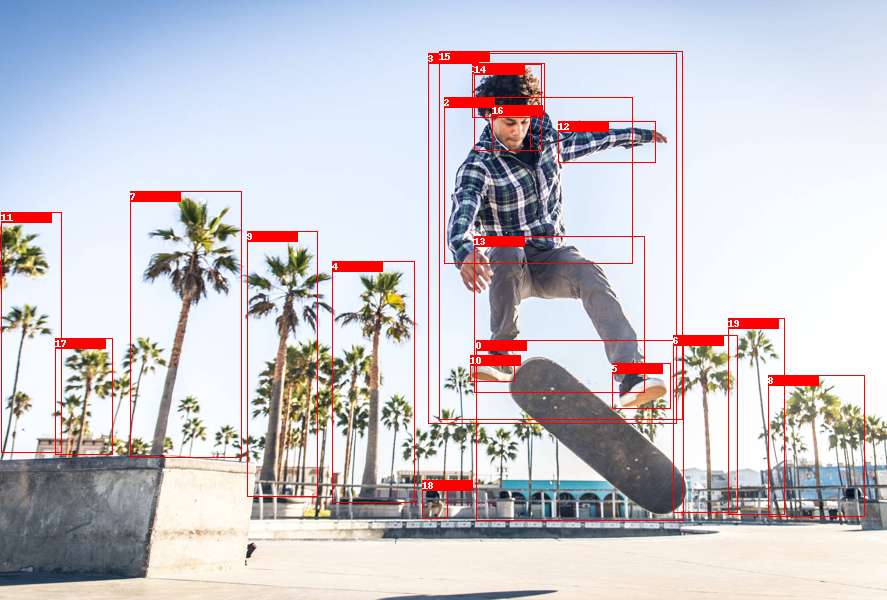

In [28]:
draw_image(img3_pth, bbox_data['0']['bbox'][:top_k], str(bbox_data['0']['bbox_labels'][:top_k]), bbox_data['0']['rel_labels'])

# Non Maximum Suppression

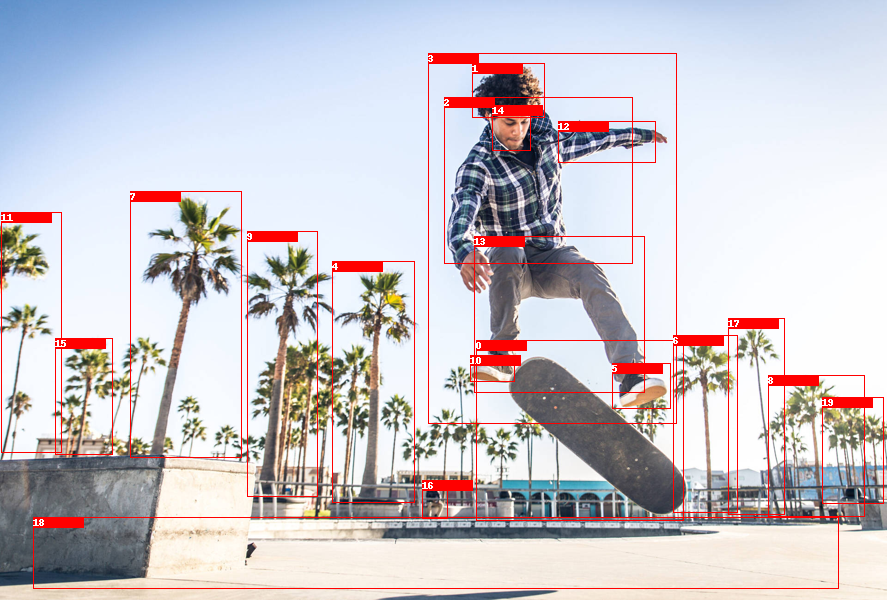

In [29]:
draw_image(img3_pth, cleaned_NMS_bbox_dict['bbox'][:top_k], str(cleaned_NMS_bbox_dict['bbox_labels'][:top_k]), cleaned_NMS_bbox_dict['rel_labels'])

In [30]:
size = get_size(Image.open(img3_pth).size)
img3_rgb_resized = np.array(Image.open(img3_pth).resize(size).convert("RGB"))

bbox_pmf_out = compute_bbox_pmfs(img3_rgb_resized,  bbox_data['0']['bbox'])

In [31]:
bbox_data['0'].keys()

dict_keys(['bbox', 'bbox_labels', 'bbox_scores', 'rel_pairs', 'rel_labels', 'rel_scores', 'rel_all_scores'])

In [32]:
def bbox_conf_pmf_mix(bbox_data, pmf_per_bbox, pmf_thresh = .3):
    bboxes = bbox_data['bbox']
    bbox_labels = bbox_data['bbox_labels']
    bbox_scores = bbox_data['bbox_scores']
    bbox_reweight = [(1-pmf_thresh)*conf + pmf_thresh*pmf for conf, pmf in zip(bbox_scores, pmf_per_bbox)]
    sorted_box_data = sorted(zip(bboxes, bbox_labels, bbox_scores, bbox_reweight), key=lambda x: x[3], reverse=True)
    bbox_sorted, labels_sorted, scores_sorted, new_weigths = zip(*sorted_box_data)
    return bbox_sorted, labels_sorted, scores_sorted, new_weigths

# Gaze 
threshold = .3

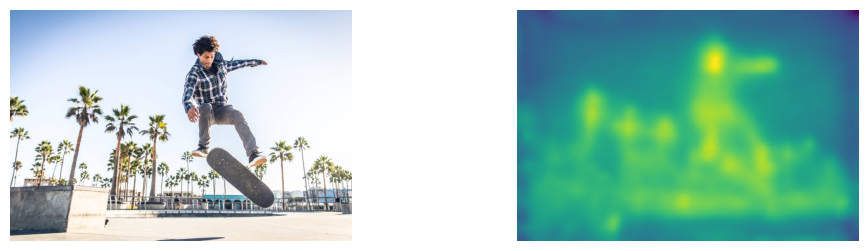

In [33]:
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
axs[0].imshow(img_rgb)
axs[0].set_axis_off()
axs[1].matshow(log_density_prediction.detach().cpu().numpy()[0, 0])  # first image in batch, first (and only) channel
axs[1].set_axis_off()

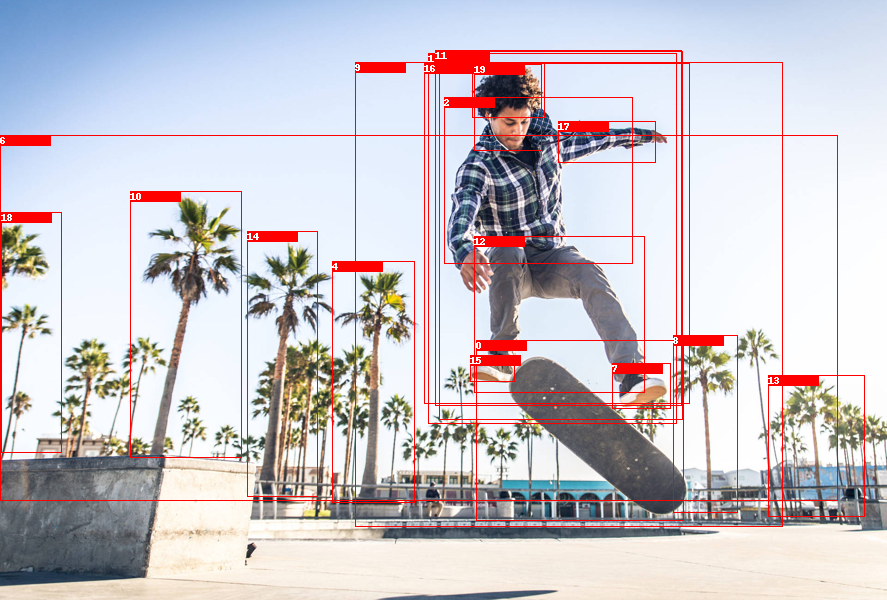

In [34]:
bbox_gaze, labels_gaze, scores_gze, new_gaze = bbox_conf_pmf_mix(bbox_data['0'], bbox_pmf_out)

draw_image(img3_pth, bbox_gaze[:top_k], str(labels_gaze[:top_k]))

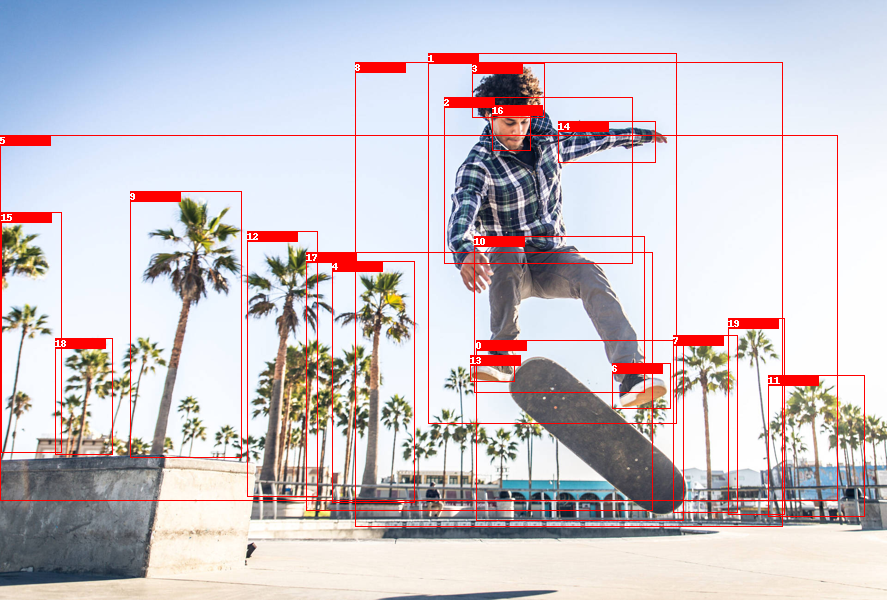

In [35]:
bbox_pmf_out = compute_bbox_pmfs(img3_rgb_resized,  cleaned_NMS_bbox_dict['bbox'])
bbox_gaze_nms, labels_gaze_nms, scores_gze_nms, new_gaze_nms = bbox_conf_pmf_mix(cleaned_NMS_bbox_dict, bbox_pmf_out)
draw_image(img3_pth, bbox_gaze_nms[:top_k], str(labels_gaze_nms[:top_k]))

In [36]:
labels_gaze_nms
scores_gze_nms
new_gaze_nms

(0.6206237733364105,
 0.5787103950977325,
 0.5078964442014694,
 0.49301731102168556,
 0.3250181816518306,
 0.3006118834018707,
 0.27464444711804387,
 0.2725453794002533,
 0.26405652826651926,
 0.23964347913861272,
 0.21665797829627992,
 0.2158500803634524,
 0.21313262060284613,
 0.19803447723388673,
 0.186476831138134,
 0.17882661416660994,
 0.1421286940574646,
 0.14103403529152272,
 0.10981910317204892,
 0.10593949174508452,
 0.10374846495687962,
 0.09311067592352627,
 0.09125018417835234,
 0.08910524249076843,
 0.0887970969080925,
 0.08320471942424773,
 0.07956193039426579,
 0.06919222325086594,
 0.060497922264039515,
 0.05866457819938659,
 0.057428642688319084,
 0.04834630778059363,
 0.04804556667804717,
 0.046633589034900065,
 0.04454994648694992,
 0.04264569950755685,
 0.042204386740922924,
 0.0420494694262743,
 0.041427905485033986,
 0.03991910871118307,
 0.03550106333568692,
 0.02649401078815572,
 0.02613608930259943,
 0.02555676270276308,
 0.02496500250417739,
 0.02415717011317